#### <b>Load Libraries</b>

* Load various useful python libraries for the experiments.

In [2]:
import os
import time
import random
import glob
from PIL import Image
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings

warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
from torchvision import datasets, transforms, models
import torchvision.transforms.functional as TF
import torch.nn.functional as F

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from sklearn import linear_model, model_selection
from sklearn.utils import shuffle


#### <b>Family Relationship Dataset</b>

1. It consists of a total of 900 households and approximately exact 13,068 individuals.
2. The last part of the filename, such as "a1", indicates the "age group".
  * This dataset consists of 8 age group classes.
  * The task is one of the 8-classes classification problem.
  * If we perform random guessing, the accuracy is approximately 12.5%.
3. The age classification problem is somewhat challenging, thus, we expect that our dataset will be helpful for evaluating the forgetting performance of a machine unlearning algorithm.
  * Our proposed setting has been configured in a way that is almost similar to the NeurIPS Kaggle Competition 2023 held on Kaggle.
4. We have utilized "Family Relationship Dataset" from AI Hub for constructing this dataset.
  * <b>Link</b>: https://www.aihub.or.kr/aihubdata/data/view.do?currMenu=&topMenu=&aihubDataSe=realm&dataSetSn=528

#### <b>Load Datasets</b>

* The following three datasets do not overlap at the household level.
  * Thus, our setting ensures any individual "subjects" are overlapped across the following three sub-dataset.
  * In other wrods, we set any person (subject) to do not simultaneously belonging to the $\mathcal{D}_{train}$, $\mathcal{D}_{test}$ and $\mathcal{D}_{unseen}$.
* <b>Training dataset $\mathcal{D}_{train}$</b>: (F0001 ~ F0299) folders have 10,025 images.
* <b>Test dataset $\mathcal{D}_{test}$</b>: (F0801 ~ F0850) folders have 1,539 images.
* <b>Unseen dataset $\mathcal{D}_{unseen}$</b>: (F0851 ~ F0900) folders have 1,504 images.

In [3]:
"""
> [Function] Parse the metadata.
* image_age_list[0] = ["F0001_AGE_D_18_a1.jpg"] = "a"
* image_age_list[1] = ["F0001_AGE_D_18_a2.jpg"] = "a"
* image_age_list[2] = ["F0001_AGE_D_18_a3.jpg"] = "a"
* image_age_list[3] = ["F0001_AGE_D_18_a4.jpg"] = "a"
* image_age_list[4] = ["F0001_AGE_D_18_b1.jpg"] = "b"
...
"""
def parsing(meta_data):
    image_age_list = []
    # iterate all rows in the metadata file
    for idx, row in meta_data.iterrows():
        image_path = row['image_path']
        age_class = row['age_class']
        image_age_list.append([image_path, age_class])
    return image_age_list

In [4]:
class Dataset(Dataset):
    def __init__(self, meta_data, image_directory, transform=None, forget=False, retrain=False):
        self.meta_data = meta_data
        self.image_directory = image_directory
        self.transform = transform

        # Process the metadata.
        image_age_list = parsing(meta_data)

        self.image_age_list = image_age_list
        self.age_class_to_label = {
            "a": 0, "b": 1, "c": 2, "d": 3, "e": 4, "f": 5, "g": 6, "h": 7
        }

        # After training the original model, we will do "machine unlearning".
        # The machine unlearning requires two datasets, ① forget dataset and ② retrain dataset.
        # In this experiment, we set the first 1,500 images to be forgotten and the rest images to be retrained.
        if forget:
            self.image_age_list = self.image_age_list[:1500]
        if retrain:
            self.image_age_list = self.image_age_list[1500:]

    def __len__(self):
        return len(self.image_age_list)

    def __getitem__(self, idx):
        image_path, age_class = self.image_age_list[idx]
        img = Image.open(os.path.join(self.image_directory, image_path))
        label = self.age_class_to_label[age_class]

        if self.transform:
            img = self.transform(img)

        return img, label

In [5]:
label_to_age = {
    0: "0-6 years old",
    1: "7-12 years old",
    2: "13-19 years old",
    3: "20-30 years old",
    4: "31-45 years old",
    5: "46-55 years old",
    6: "56-66 years old",
    7: "67-80 years old"
}

train_meta_data_path = "./custom_korean_family_dataset_resolution_128/custom_train_dataset.csv"
train_meta_data = pd.read_csv(train_meta_data_path)
train_image_directory = "./custom_korean_family_dataset_resolution_128/train_images"

test_meta_data_path = "./custom_korean_family_dataset_resolution_128/custom_val_dataset.csv"
test_meta_data = pd.read_csv(test_meta_data_path)
test_image_directory = "./custom_korean_family_dataset_resolution_128/val_images"

unseen_meta_data_path = "./custom_korean_family_dataset_resolution_128/custom_test_dataset.csv"
unseen_meta_data = pd.read_csv(unseen_meta_data_path)
unseen_meta_data = shuffle(unseen_meta_data, random_state=42)
unseen_image_directory = "./custom_korean_family_dataset_resolution_128/test_images"

train_transform = transforms.Compose([
    transforms.Resize(128),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(128),
    transforms.ToTensor()
])

unseen_transform = transforms.Compose([
    transforms.Resize(128),
    transforms.ToTensor()
])

train_dataset = Dataset(train_meta_data, train_image_directory, train_transform)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)

test_dataset = Dataset(test_meta_data, test_image_directory, test_transform)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

unseen_dataset_train = Dataset(unseen_meta_data[:int(len(unseen_meta_data) * 0.8)], unseen_image_directory, unseen_transform)
unseen_dataloader_train = DataLoader(unseen_dataset_train, batch_size=64, shuffle=False)

unseen_dataset_test = Dataset(unseen_meta_data[int(len(unseen_meta_data) * 0.8):], unseen_image_directory, unseen_transform)
unseen_dataloader_test = DataLoader(unseen_dataset_test, batch_size=64, shuffle=False)

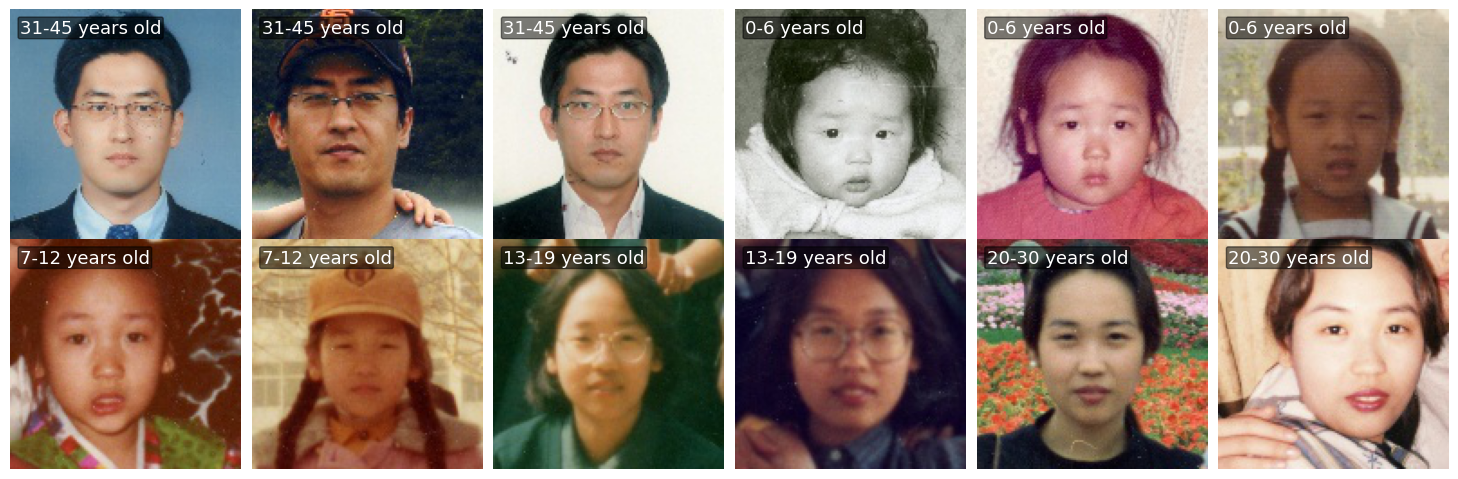

In [6]:
def show_images(images, labels, nrow=6, save_path=None):
    n_images = len(images)
    nrows = n_images // nrow + (n_images % nrow > 0)

    fig, axs = plt.subplots(nrows, nrow, figsize=(14.5, 2.3 * nrows), frameon=False)
    axs = axs.flatten() if n_images > 1 else [axs]

    for idx, (img, label) in enumerate(zip(images, labels)):
        ax = axs[idx]
        img_np = img.numpy().transpose((1, 2, 0))
   
        ax.imshow(img_np)
        ax.axis('off')

        ax.text(5, 5, label, color='white', fontsize=13,  ha='left', va='top',
                bbox=dict(facecolor='black', alpha=0.5, boxstyle='round,pad=0.1'))

    plt.tight_layout(pad=0)

    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)

    plt.show()

iterator = iter(test_dataloader)
imgs, labels = next(iterator)

label_strs = [label_to_age[label.item()] for label in labels[7:19]]

show_images(imgs[7:19], label_strs, nrow=6)

In [7]:
@torch.no_grad()
def evaluation(model, data_loader):
    start_time = time.time()
    print(f'[Test]')
    model.eval()
    total = 0
    running_loss = 0.0
    running_corrects = 0
    running_top2_corrects = 0

    for i, batch in enumerate(data_loader):
        imgs, labels = batch
        imgs, labels = imgs.cuda(), labels.cuda()

        with torch.no_grad():
            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            # Top-2 accuracy.
            _, top2_preds = outputs.topk(2, dim=1)  # Get the top 2 class indices.
            top2_correct = top2_preds.eq(labels.view(-1, 1).expand_as(top2_preds))
            running_top2_corrects += top2_correct.any(dim=1).sum().item()

        total += labels.shape[0]
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data).item()

        if (i == 0) or (i % log_step == log_step - 1):
            print(f'[Batch: {i + 1}] running test loss: {running_loss / total}, running test accuracy: {running_corrects / total}, running top-2 accuracy: {running_top2_corrects / total}')

    print(f'test loss: {running_loss / total}, accuracy: {running_corrects / total}, top-2 accuracy: {running_top2_corrects / total}')
    print("elapsed time:", time.time() - start_time)
    return {'Loss': running_loss / total, 'Acc': running_corrects / total, 'Top-2 Acc': running_top2_corrects / total}

def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)

In [80]:
def compute_losses(net, loader):
    criterion = nn.CrossEntropyLoss(reduction="none")
    all_losses = []

    for inputs, y in loader:
        targets = y
        inputs, targets = inputs.cuda(), targets.cuda()
       
        logits = net(inputs)
        losses = criterion(logits, targets).cpu().detach().numpy()
            
        for l in losses:
            all_losses.append(l)

    return np.array(all_losses)

def simple_mia(sample_loss, members, n_splits=10, random_state=0):
    unique_members = np.unique(members)
    if not np.all(unique_members == np.array([0, 1])):
        raise ValueError("members should only have 0 and 1s")

    attack_model = linear_model.LogisticRegression()
    cv = model_selection.StratifiedShuffleSplit(
        n_splits=n_splits, random_state=random_state
    )
    return model_selection.cross_val_score(
        attack_model, sample_loss, members, cv=cv, scoring="accuracy"
    )

def cal_mia(model, unseen_dataloader):
    set_seed(42)

    forget_losses = compute_losses(model, forget_dataloader_test)
    unseen_losses = compute_losses(model, unseen_dataloader)

    np.random.shuffle(forget_losses)
    forget_losses = forget_losses[: len(unseen_losses)]

    samples_mia = np.concatenate((unseen_losses, forget_losses)).reshape((-1, 1))
    labels_mia = [0] * len(unseen_losses) + [1] * len(forget_losses)

    mia_scores = simple_mia(samples_mia, labels_mia)
    forgetting_score = abs(0.5 - mia_scores.mean())

    return {'MIA': mia_scores.mean(), 'Forgeting Score': forgetting_score}, unseen_losses, forget_losses

def plot_mia_scatter(unseen_losses, forget_losses, unseen_dataloader):
    y_unseen = []
    for _, labels in unseen_dataloader:
        y_unseen.extend(labels.numpy())

    y_forget = []
    for _, labels in forget_dataloader_test:
        y_forget.extend(labels.numpy())

    y_unseen = np.array(y_unseen)
    y_forget = np.array(y_forget)[: len(y_unseen)]

    plt.figure(figsize=(8, 5))
    plt.scatter(unseen_losses, y_unseen, color='skyblue', label='Unseen dataset', alpha=0.6)
    plt.scatter(forget_losses, y_forget, color='lightcoral', label='Forget dataset', alpha=0.6)

    # Cài đặt trục
    plt.xlabel("Loss Value")
    plt.ylabel("Class")
    plt.title("Showing Model's Recognition of Unseen and Forget Datasets")
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=2)
    plt.grid(alpha=0.3)
    plt.show()

In [18]:
def train():
    start_time = time.time()
    print(f'[Epoch: {epoch + 1} - Training]')
    model.train()
    total = 0
    running_loss = 0.0
    running_corrects = 0

    for i, batch in enumerate(train_dataloader):
        imgs, labels = batch
        print(batch)
        imgs, labels = imgs.cuda(), labels.cuda()

        outputs = model(imgs)
        optimizer.zero_grad()
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        total += labels.shape[0]
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)

        if i % log_step == log_step - 1:
            print(f'[Batch: {i + 1}] running train loss: {running_loss / total}, running train accuracy: {running_corrects / total}')

    print(f'train loss: {running_loss / total}, accuracy: {running_corrects / total}')
    print("elapsed time:", time.time() - start_time)
    return running_loss / total, (running_corrects / total).item()


def test():
    start_time = time.time()
    print(f'[Test]')
    model.eval()
    total = 0
    running_loss = 0.0
    running_corrects = 0

    for i, batch in enumerate(test_dataloader):
        imgs, labels = batch
        imgs, labels = imgs.cuda(), labels.cuda()

        with torch.no_grad():
            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

        total += labels.shape[0]
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)

        if (i == 0) or (i % log_step == log_step - 1):
            print(f'[Batch: {i + 1}] running test loss: {running_loss / total}, running test accuracy: {running_corrects / total}')

    print(f'test loss: {running_loss / total}, accuracy: {running_corrects / total}')
    print("elapsed time:", time.time() - start_time)
    return running_loss / total, (running_corrects / total).item()

#### <b>Machine Unlearning Experiments</b>

* In the NeurIPS Competition setting, when performing machine unlearning, training is done with 'retrain' and 'forget', so augmentation can be applied. However, it should never be applied during evaluation.
* We divide training dataset $\mathcal{D}_{train}$ into a retrain dataset $\mathcal{D}_{retrain}$ and a forget dataset $\mathcal{D}_{forget}$.

In [19]:
batch_size_forget_unseen = 64

forget_dataset_train = Dataset(train_meta_data, train_image_directory, train_transform, forget=True)
forget_dataloader_train = DataLoader(forget_dataset_train, batch_size=batch_size_forget_unseen, shuffle=False)

retrain_dataset_train = Dataset(train_meta_data, train_image_directory, train_transform, retrain=True)
retrain_dataloader_train = DataLoader(retrain_dataset_train, batch_size=64, shuffle=True)

forget_dataset_test = Dataset(train_meta_data, train_image_directory, test_transform, forget=True)
forget_dataloader_test = DataLoader(forget_dataset_test, batch_size=64, shuffle=False)

retrain_dataset_test = Dataset(train_meta_data, train_image_directory, test_transform, retrain=True)
retrain_dataloader_test = DataLoader(retrain_dataset_test, batch_size=64, shuffle=False)

In [20]:
print('Train dataset size:', len(train_dataset))
print('Test dataset size:', len(test_dataset))
print('Forget dataset size:', len(forget_dataset_train))
print('retrain dataset size:', len(retrain_dataset_train))
print('Unseen dataset size:', len(unseen_dataset_train))

Train dataset size: 10025
Test dataset size: 1539
Forget dataset size: 1500
retrain dataset size: 8525
Unseen dataset size: 1203


In [21]:
# Checking for duplicates across datasets
train_image_paths = [x[0] for x in train_dataset.image_age_list]
test_image_paths = [x[0] for x in test_dataset.image_age_list]
forget_image_paths = [x[0] for x in forget_dataset_train.image_age_list]
retrain_image_paths = [x[0] for x in retrain_dataset_train.image_age_list]
unseen_image_paths = [x[0] for x in unseen_dataset_train.image_age_list]

train_test_overlap = len(set(train_image_paths) & set(test_image_paths))
train_forget_overlap = len(set(train_image_paths) & set(forget_image_paths))
train_retrain_overlap = len(set(train_image_paths) & set(retrain_image_paths))
train_unseen_overlap = len(set(train_image_paths) & set(unseen_image_paths))
test_forget_overlap = len(set(test_image_paths) & set(forget_image_paths))
test_retrain_overlap = len(set(test_image_paths) & set(retrain_image_paths))
test_unseen_overlap = len(set(test_image_paths) & set(unseen_image_paths))
forget_retrain_overlap = len(set(forget_image_paths) & set(retrain_image_paths))
forget_unseen_overlap = len(set(forget_image_paths) & set(unseen_image_paths))
retrain_unseen_overlap = len(set(retrain_image_paths) & set(unseen_image_paths))

overlap_dict = {
    'train_test': train_test_overlap,
    'train_forget': train_forget_overlap,
    'train_retrain': train_retrain_overlap,
    'train_unseen': train_unseen_overlap,
    'test_forget': test_forget_overlap,
    'test_retrain': test_retrain_overlap,
    'test_unseen': test_unseen_overlap,
    'forget_retrain': forget_retrain_overlap,
    'forget_unseen': forget_unseen_overlap,
    'retrain_unseen': retrain_unseen_overlap
}
overlap_dict

{'train_test': 0,
 'train_forget': 1500,
 'train_retrain': 8525,
 'train_unseen': 0,
 'test_forget': 0,
 'test_retrain': 0,
 'test_unseen': 0,
 'forget_retrain': 0,
 'forget_unseen': 0,
 'retrain_unseen': 0}

# Step 1: Forgetting via PIU-FR

In [57]:
random.seed(42)

In [ ]:
original_save_path = f'last_checkpoint_epoch_30_MUFAC.pth'
original_model = models.resnet18(pretrained=False)
num_features = original_model.fc.in_features
original_model.fc = nn.Linear(num_features, 8)
original_model.load_state_dict(torch.load(original_save_path))
original_model = original_model.cuda()
criterion = nn.CrossEntropyLoss()

In [85]:
# Performance
log_step = 30
test_acc = evaluation(original_model, test_dataloader)
unseen_acc = evaluation(original_model, unseen_dataloader_test)
mia, unseen_losses, forget_losses = cal_mia(original_model.cuda(), unseen_dataloader_test)
print(f'Test Acc: {test_acc}')
print(f'Unseen Acc: {unseen_acc}')
print(f'MIA: {mia}')
print(f'Final Score: {(test_acc["Acc"] + (1 - abs(mia["MIA"] - 0.5) * 2)) / 2}')

[Test]
[Batch: 1] running test loss: 0.023212511092424393, running test accuracy: 0.65625, running top-2 accuracy: 0.9375
test loss: 0.026598462390775724, accuracy: 0.5971410006497726, top-2 accuracy: 0.8856400259909032
elapsed time: 3.521751642227173
[Test]
[Batch: 1] running test loss: 0.015163203701376915, running test accuracy: 0.734375, running top-2 accuracy: 0.921875
test loss: 0.021992595488842935, accuracy: 0.6710963455149501, top-2 accuracy: 0.8803986710963455
elapsed time: 0.5386652946472168
Test Acc: {'Loss': 0.026598462390775724, 'Acc': 0.5971410006497726, 'Top-2 Acc': 0.8856400259909032}
Unseen Acc: {'Loss': 0.021992595488842935, 'Acc': 0.6710963455149501, 'Top-2 Acc': 0.8803986710963455}
MIA: {'MIA': 0.6786885245901638, 'Forgeting Score': 0.17868852459016382}
Final Score: 0.6198819757347225


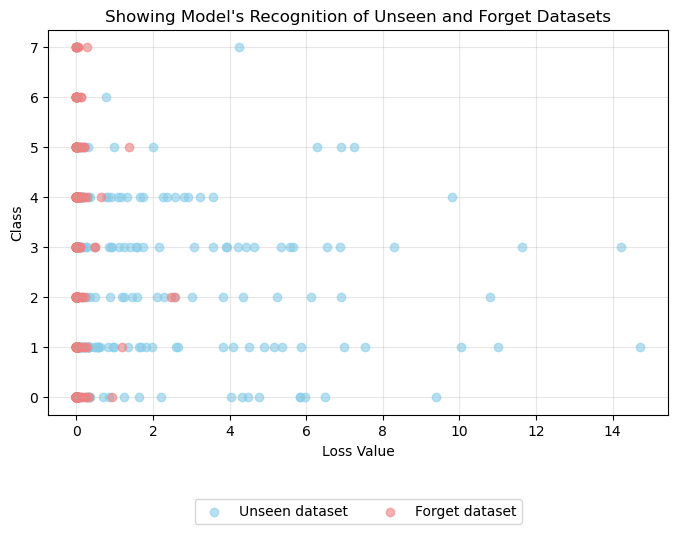

In [86]:
plot_mia_scatter(unseen_losses, forget_losses, unseen_dataloader_test)

In [ ]:
original_save_path = f'last_checkpoint_epoch_30_MUFAC.pth'
forgot_model = models.resnet18(pretrained=False)
num_features = forgot_model.fc.in_features
forgot_model.fc = nn.Linear(num_features, 8)
forgot_model.load_state_dict(torch.load(original_save_path))
forgot_model = forgot_model.cuda()
criterion = nn.CrossEntropyLoss()

In [34]:
class DistillKL(nn.Module):
    def __init__(self, T):
        super(DistillKL, self).__init__()
        self.T = T

    def forward(self, y_s, y_t):
        p_s = F.log_softmax(y_s/self.T, dim=1)
        p_t = F.softmax(y_t/self.T, dim=1)
        loss = F.kl_div(p_s, p_t, size_average=False) * (self.T**2) / y_s.shape[0]
        return loss

In [35]:
class New_Unseen_Dataset(Dataset):
    def __init__(self, meta_data, image_directory, transform=None, forget_dataloader=None):
        self.meta_data = meta_data
        self.image_directory = image_directory
        self.transform = transform
        self.forget_dataloader = forget_dataloader

        # Process the metadata.
        image_age_list = parsing(meta_data)

        self.age_class_to_label = {
            "a": 0, "b": 1, "c": 2, "d": 3, "e": 4, "f": 5, "g": 6, "h": 7
        }

        new_image_age_list = []
        
        dict_image_lists = {}
        for image_path, age_class in image_age_list:
            if self.age_class_to_label[age_class] not in dict_image_lists:
                dict_image_lists[self.age_class_to_label[age_class]] = [(image_path, age_class)]
            else:
                dict_image_lists[self.age_class_to_label[age_class]].append((image_path, age_class))

        for inputs_forget, labels_forget in forget_dataloader:
            labels_forget = labels_forget.cpu().numpy()  # Convert to numpy array for easier handling
            
            for label in labels_forget:
                same_class_samples = dict_image_lists[label]
                
                if same_class_samples:
                    chosen_sample = random.choice(same_class_samples)
                    new_image_age_list.append(chosen_sample)
        
        self.image_age_list = new_image_age_list

    def __len__(self):
        return len(self.image_age_list)

    def __getitem__(self, idx):
        image_path, age_class = self.image_age_list[idx]
        img = Image.open(os.path.join(self.image_directory, image_path))
        label = self.age_class_to_label[age_class]

        if self.transform:
            img = self.transform(img)

        return img, label    

In [38]:
class Forgetting_Function:
    def __init__(self, original_model, forgot_model, forget_dataloader):
        self.original_model = original_model
        self.forgot_model = forgot_model
        self.forget_dataloader = forget_dataloader
        #self.retrain_dataloader = retrain_dataloader
        self.criterion_div = DistillKL(4.0)
        self.optimizer = optim.SGD(self.forgot_model.parameters(), lr=0.001)
        self.criterion = torch.nn.CrossEntropyLoss()

    def train_epoch(self):
        set_seed(42)
        self.forgot_model.train()
        self.original_model.eval()

        # Function to compute accuracy.
        def compute_accuracy(outputs, labels):
            _, predicted = outputs.max(1)
            total = labels.size(0)
            correct = predicted.eq(labels).sum().item()
            return 100 * correct / total

        total_loss_div, total_accuracy_forget = 0, 0
        
        # Process new unseen_dataloader
        new_unseen_dataset = New_Unseen_Dataset(unseen_meta_data[:int(len(unseen_meta_data) * 0.8)], unseen_image_directory, unseen_transform,  self.forget_dataloader)
        new_unseen_dataloader = DataLoader(new_unseen_dataset, batch_size=batch_size_forget_unseen, shuffle=False)
        
        # Training with unseen data.
        flag = 1

        for (inputs_unseen, labels_unseen), (inputs_forget, labels_forget) in zip(new_unseen_dataloader, self.forget_dataloader):
            inputs_unseen, labels_unseen = inputs_unseen.cuda(), labels_unseen.cuda()
            inputs_forget, labels_forget = inputs_forget.cuda(), labels_forget.cuda()

            outputs_forget = self.forgot_model(inputs_forget)

            with torch.no_grad():
                outputs_unseen = self.original_model(inputs_unseen)

            # Loss computation
            loss_div = flag * self.criterion_div(outputs_forget, outputs_unseen)

            # Update total loss and accuracy for unseen data.
            total_loss_div += loss_div.item()
            total_accuracy_forget += compute_accuracy(outputs_forget, labels_forget)

            # Backward pass
            self.optimizer.zero_grad()
            loss_div.backward()
            self.optimizer.step()
            
            if flag == 1:
                flag = -1
            else:
                flag = 1

        # Print average loss and accuracy for the entire epoch
        avg_loss_div = total_loss_div / len(self.forget_dataloader)
        avg_accuracy_forget = total_accuracy_forget / len(self.forget_dataloader)

        mia, unseen_losses, forget_losses = cal_mia(self.forgot_model.cuda(), unseen_dataloader_train)

        print(f'Epoch unseen: Avg Loss: {avg_loss_div:.4f}, Avg Accuracy: {avg_accuracy_forget:.2f}, Forgeting Score: {mia["Forgeting Score"]}')

In [39]:
set_seed(42)

# Initialize and train
forgetting_trainer = Forgetting_Function(original_model, forgot_model, forget_dataloader_train)

num_epochs = 10
for epoch in range(num_epochs):
    forgetting_trainer.train_epoch()
    print(f"Epoch {epoch+1} completed.")

Epoch unseen: Avg Loss: -1.4713, Avg Accuracy: 92.19, Forgeting Score: 0.1697095435684648
Epoch 1 completed.
Epoch unseen: Avg Loss: -3.1657, Avg Accuracy: 89.04, Forgeting Score: 0.14854771784232368
Epoch 2 completed.
Epoch unseen: Avg Loss: -5.0292, Avg Accuracy: 84.81, Forgeting Score: 0.13402489626556013
Epoch 3 completed.
Epoch unseen: Avg Loss: -7.1508, Avg Accuracy: 80.69, Forgeting Score: 0.11535269709543572
Epoch 4 completed.
Epoch unseen: Avg Loss: -9.6960, Avg Accuracy: 76.00, Forgeting Score: 0.09211618257261411
Epoch 5 completed.
Epoch unseen: Avg Loss: -12.8877, Avg Accuracy: 70.50, Forgeting Score: 0.08755186721991692
Epoch 6 completed.
Epoch unseen: Avg Loss: -17.0642, Avg Accuracy: 66.53, Forgeting Score: 0.0713692946058091
Epoch 7 completed.
Epoch unseen: Avg Loss: -22.6772, Avg Accuracy: 61.35, Forgeting Score: 0.060995850622406644
Epoch 8 completed.
Epoch unseen: Avg Loss: -30.2989, Avg Accuracy: 57.68, Forgeting Score: 0.045643153526971014
Epoch 9 completed.
Epoch 

In [40]:
# Performance
log_step = 30
test_acc = evaluation(forgot_model, test_dataloader)
unseen_acc = evaluation(forgot_model, unseen_dataloader_test)
mia, unseen_losses, forget_losses = cal_mia(forgot_model.cuda(), unseen_dataloader_test)
print(f'Test Acc: {test_acc}')
print(f'Unseen Acc: {unseen_acc}')
print(f'MIA: {mia}')
print(f'Final Score: {(test_acc["Acc"] + (1 - abs(mia["MIA"] - 0.5) * 2)) / 2}')

[Test]
[Batch: 1] running test loss: 0.13996915519237518, running test accuracy: 0.453125, running top-2 accuracy: 0.640625
test loss: 0.1618433884787358, accuracy: 0.4405458089668616, top-2 accuracy: 0.6855100714749838
elapsed time: 3.0242862701416016
[Test]
[Batch: 1] running test loss: 0.12306654453277588, running test accuracy: 0.515625, running top-2 accuracy: 0.6875
test loss: 0.13184965963775533, accuracy: 0.4584717607973422, top-2 accuracy: 0.7043189368770764
elapsed time: 0.5698235034942627
Test Acc: {'Loss': 0.1618433884787358, 'Acc': 0.4405458089668616, 'Top-2 Acc': 0.6855100714749838}
Unseen Acc: {'Loss': 0.13184965963775533, 'Acc': 0.4584717607973422, 'Top-2 Acc': 0.7043189368770764}
MIA: {'MIA': 0.542622950819672, 'Forgeting Score': 0.042622950819672045}
Final Score: 0.6776499536637588


# Step 2: Improve accuracy (Optional)

In [42]:
def train_model_using_only_retrain(model):
    start_time = time.time()
    print(f'[Epoch: {epoch + 1} - Training]')
    model.train()
    total = 0
    running_loss = 0.0
    running_corrects = 0

    for i, batch in enumerate(retrain_dataloader_train):
        imgs, labels = batch
        imgs, labels = imgs.cuda(), labels.cuda()

        outputs = model(imgs)
        optimizer.zero_grad()
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        total += labels.shape[0]
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)

        if i % log_step == log_step - 1:
            print(f'[Batch: {i + 1}] running train loss: {running_loss / total}, running train accuracy: {running_corrects / total}')

    print(f'train loss: {running_loss / total}, accuracy: {running_corrects / total}')
    print("elapsed time:", time.time() - start_time)
    return running_loss / total, (running_corrects / total).item()

def test_model(model):
    start_time = time.time()
    print(f'[Test]')
    model.eval()
    total = 0
    running_loss = 0.0
    running_corrects = 0

    for i, batch in enumerate(test_dataloader):
        imgs, labels = batch
        imgs, labels = imgs.cuda(), labels.cuda()

        with torch.no_grad():
            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

        total += labels.shape[0]
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)

        if (i == 0) or (i % log_step == log_step - 1):
            print(f'[Batch: {i + 1}] running test loss: {running_loss / total}, running test accuracy: {running_corrects / total}')

    print(f'test loss: {running_loss / total}, accuracy: {running_corrects / total}')
    print("elapsed time:", time.time() - start_time)
    return running_loss / total, (running_corrects / total).item()
    
def adjust_learning_rate(optimizer, epoch):
    lr = learning_rate
    if epoch >= 10:
        lr /= 10
    if epoch >= 20:
        lr /= 10
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [43]:
num_epochs = 2
learning_rate = 0.01
log_step = 30

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(forgot_model.parameters(), lr=learning_rate, momentum=0.9)

for epoch in range(num_epochs):
    adjust_learning_rate(optimizer, epoch)
    train_loss, train_acc = train_model_using_only_retrain(forgot_model)
    test_loss, test_acc = test_model(forgot_model)

[Epoch: 1 - Training]
[Batch: 30] running train loss: 0.02461500552793344, running train accuracy: 0.5250000357627869
[Batch: 60] running train loss: 0.020877032695959013, running train accuracy: 0.5552083849906921
[Batch: 90] running train loss: 0.018391082663502957, running train accuracy: 0.5842013955116272
[Batch: 120] running train loss: 0.016841192722010116, running train accuracy: 0.608593761920929
train loss: 0.01628941564266283, accuracy: 0.6199413537979126
elapsed time: 129.30549669265747
[Test]
[Batch: 1] running test loss: 0.019299523904919624, running test accuracy: 0.5
test loss: 0.021829434460521595, accuracy: 0.4931773841381073
elapsed time: 3.030177593231201
[Epoch: 2 - Training]
[Batch: 30] running train loss: 0.009671356482431292, running train accuracy: 0.7473958730697632
[Batch: 60] running train loss: 0.009417564383087058, running train accuracy: 0.7557291984558105
[Batch: 90] running train loss: 0.009209994469872779, running train accuracy: 0.7654514312744141
[Ba

In [44]:
# Performance
log_step = 30
test_acc = evaluation(forgot_model, test_dataloader)
unseen_acc = evaluation(forgot_model, unseen_dataloader_test)
mia, unseen_losses, forget_losses = cal_mia(forgot_model.cuda(), unseen_dataloader_test)
print(f'Test Acc: {test_acc}')
print(f'Unseen Acc: {unseen_acc}')
print(f'MIA: {mia}')
print(f'Final Score: {(test_acc["Acc"] + (1 - abs(mia["MIA"] - 0.5) * 2)) / 2}')

[Test]
[Batch: 1] running test loss: 0.01990116387605667, running test accuracy: 0.65625, running top-2 accuracy: 0.828125
test loss: 0.02518418425472624, accuracy: 0.5373619233268356, top-2 accuracy: 0.7777777777777778
elapsed time: 2.7684736251831055
[Test]
[Batch: 1] running test loss: 0.016451876610517502, running test accuracy: 0.625, running top-2 accuracy: 0.84375
test loss: 0.022571105101575884, accuracy: 0.5514950166112956, top-2 accuracy: 0.8106312292358804
elapsed time: 0.5936489105224609
Test Acc: {'Loss': 0.02518418425472624, 'Acc': 0.5373619233268356, 'Top-2 Acc': 0.7777777777777778}
Unseen Acc: {'Loss': 0.022571105101575884, 'Acc': 0.5514950166112956, 'Top-2 Acc': 0.8106312292358804}
MIA: {'MIA': 0.5442622950819671, 'Forgeting Score': 0.04426229508196711}
Final Score: 0.7244186665814507


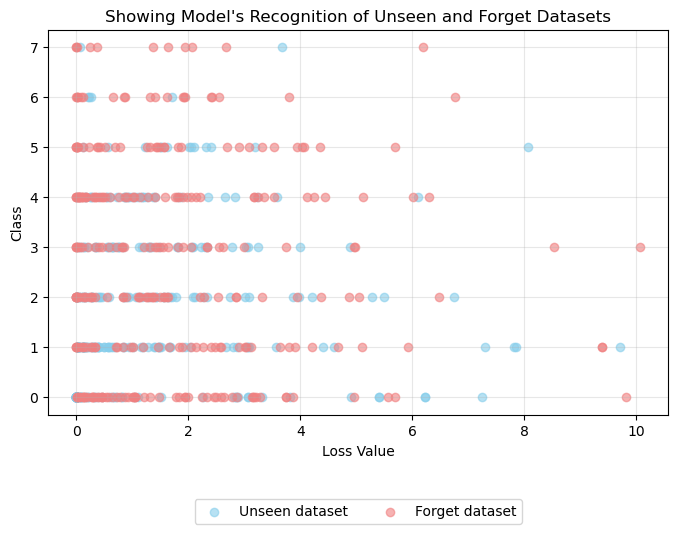

In [82]:
plot_mia_scatter(unseen_losses, forget_losses, unseen_dataloader_test)

# Compare With Retrained Model

In [87]:
num_epochs = 30

retrained_model = models.resnet18(pretrained=False)
num_features = retrained_model.fc.in_features
retrained_model.fc = nn.Linear(num_features, 8)
retrained_model = retrained_model.cuda()
criterion = nn.CrossEntropyLoss()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(retrained_model.parameters(), lr=learning_rate, momentum=0.9)

for epoch in range(num_epochs):
    adjust_learning_rate(optimizer, epoch)
    train_loss, train_acc = train_model_using_only_retrain(retrained_model)
    test_loss, test_acc = test_model(retrained_model)

[Epoch: 1 - Training]
[Batch: 30] running train loss: 0.031863321798543134, running train accuracy: 0.21197918057441711
[Batch: 60] running train loss: 0.03138475607459744, running train accuracy: 0.21953126788139343
[Batch: 90] running train loss: 0.03102082090659274, running train accuracy: 0.236111119389534
[Batch: 120] running train loss: 0.03036475310412546, running train accuracy: 0.25338542461395264
train loss: 0.030180966958971666, accuracy: 0.25876832008361816
elapsed time: 42.00024914741516
[Test]
[Batch: 1] running test loss: 0.03014807030558586, running test accuracy: 0.3125
test loss: 0.030975295863730944, accuracy: 0.3066926598548889
elapsed time: 2.821442127227783
[Epoch: 2 - Training]
[Batch: 30] running train loss: 0.027358012335995833, running train accuracy: 0.3411458432674408
[Batch: 60] running train loss: 0.026866701990365983, running train accuracy: 0.3398437798023224
[Batch: 90] running train loss: 0.026194441628952823, running train accuracy: 0.3510416746139526

In [88]:
# Performance
test_acc = evaluation(retrained_model, test_dataloader)
unseen_acc = evaluation(retrained_model, unseen_dataloader_test)
mia, unseen_losses, forget_losses = cal_mia(retrained_model.cuda(), unseen_dataloader_test)
print(f'Test Acc: {test_acc}')
print(f'Unseen Acc: {unseen_acc}')
print(f'MIA: {mia}')
print(f'Final Score: {(test_acc["Acc"] + (1 - abs(mia["MIA"] - 0.5) * 2)) / 2}')

[Test]
[Batch: 1] running test loss: 0.02250935137271881, running test accuracy: 0.53125, running top-2 accuracy: 0.78125
test loss: 0.02526940627094985, accuracy: 0.4899285250162443, top-2 accuracy: 0.764782326185835
elapsed time: 2.690704822540283
[Test]
[Batch: 1] running test loss: 0.01826930232346058, running test accuracy: 0.53125, running top-2 accuracy: 0.828125
test loss: 0.022638554192856698, accuracy: 0.5249169435215947, top-2 accuracy: 0.7873754152823921
elapsed time: 0.5994868278503418
Test Acc: {'Loss': 0.02526940627094985, 'Acc': 0.4899285250162443, 'Top-2 Acc': 0.764782326185835}
Unseen Acc: {'Loss': 0.022638554192856698, 'Acc': 0.5249169435215947, 'Top-2 Acc': 0.7873754152823921}
MIA: {'MIA': 0.5278688524590164, 'Forgeting Score': 0.02786885245901638}
Final Score: 0.7170954100491058


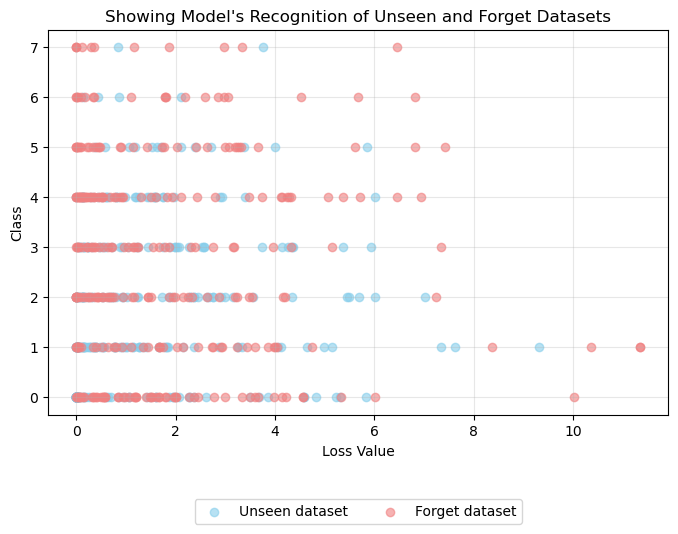

In [89]:
plot_mia_scatter(unseen_losses, forget_losses, unseen_dataloader_test)